# HSE 2023: Введение в машинное обучение БИ 22/23

## Домашнее задание № 3


# Внимание!

* Некоторые задания требуют значительного времени для выполнения (особенно часть с лемматизацией), поэтому **лучше приступить к выполнению домашнего задания как можно раньше**

* Решения обязательно должны содержать комментарии, все полученные результаты должны сопровождаться выводами (для этого удобно использовать ячейки markdown)

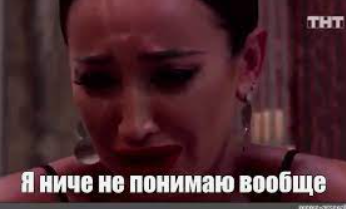

In [ ]:
import warnings

In [ ]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

## ЧАСТЬ 1: Логистическая регрессия

Будем решать задачу бинарной классификации с помошью логистической регрессии.
Для борьбы с переобучением будем использовать регуляризацию - комбинацию $L_1$ и $L_2$ (Elastic Net loss).

Для каждого объекта обучающей выборки, заданного своим признаковым описанием $x_i\in\mathbb{R}^{K}$ (вектор из $k$ признаков), указан его класс $y_i$ (одно из двух значений). Параметрами модели являются смещение $w_0\in\mathbb{R}$ и веса $w\in\mathbb{R}^K$.

Таким образом, оптимизируемый функционал (Elastic Net loss) можно записать в виде:

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 балла] Запишите формулу градиента Elastic Net loss (с выводом этой формулы, для форматирования лучше использовать Latex)


*Решение*
$$
\begin{align*}
\text{ElasticNetLoss}(w, w_0) &= \text{LogLoss} + \gamma L_1 + \beta L_2 \\
\end{align*}
$$
где
$$
\begin{align*}
\text{LogLoss} &= {1 \over N} \sum_{i = 1}^N \ln (1 + e^{-y_i(w^T x_i + w_0)}) \\
L_1 &= \| w \|_1 \\
L_2 &= \| w \|_2^2
\end{align*}
$$
Найдем производные каждого слагаемого:
$$
\frac{\partial \text{LogLoss}}{\partial w} = {1 \over N} \sum_{i = 1}^N \frac{1}{1 + e^{-y_i \cdot (w^T x_i + w_0)}} \cdot e^{-y_i(w^T x_i + w_0)} \cdot (-y_i x_i)
= - {1 \over N} \sum_{i = 1}^N  \frac{y_i x_i}{1 + e^{y_i(w^T x_i + w_0)}} \\
$$
Далее
$$
{\partial L_1 \over \partial w} = \text{sign}(w) \\
$$
так как
$$
{\partial L_1 \over \partial w_i} = {\partial \over \partial w_i} (|w_1| + |w_2| + \ldots + |w_n|) = \text{sign}(w_i)
$$
и последнее:
$$
{\partial L_2 \over \partial w} = 2 w
$$
так как
$$
{\partial L_2 \over \partial w_i} = {\partial \over \partial w_i} (w_1^2 + w_2^2 + \ldots + w_n^2) = 2 w_i
$$
Теперь найдем производную по $w_0$:
$$
\frac{\partial \text{ElasticNetLoss}}{\partial w_0} = \frac{\partial \text{LogLoss}}{\partial w_0} = {1 \over N} \sum_{i = 1}^N \frac{1}{1 + e^{-y_i \cdot (w^T x_i + w_0)}} \cdot e^{-y_i(w^T x_i + w_0)} \cdot (-y_i) = - {1 \over N} \sum_{i = 1}^N  \frac{y_i}{1 + e^{y_i(w^T x_i + w_0)}}
$$

#### 2. [0.25 балла] Реализуйте функцию вычисления Elastic Net loss

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

In [ ]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    z = y * (np.dot(X, w) + w0)
    loss = np.sum(np.log(1 + np.exp(-z)))/len(y)
    L1_g = gamma * np.linalg.norm(w, ord=1)
    L2_b = beta * np.linalg.norm(w, ord=2) ** 2
    return loss + L1_g + L2_b

#### 3. [0.25 балла] Реализуйте функцию вычисления градиента

In [ ]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    dw = -np.dot(X.T, y * np.exp(-(y * (np.dot(X, w) + w0))) / (1 + np.exp(-(y * (np.dot(X, w) + w0))))) / len(y)
    dw0 = -np.sum(y*np.exp(-(y * (np.dot(X, w) + w0))) / (1 + np.exp(-(y * (np.dot(X, w) + w0))))) / len(y)

    grad_w = dw + gamma * np.sign(w) + 2 * beta * w

    return grad_w, dw0


#### Проверьте корректность реализованных функций

In [ ]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()
grad_w, grad_w0 = get_grad(X, y, w, w0, 1, 1)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  4. [1 балл]  Реализуйте алгоритм градиентного спуска, поддержав различные критерии остановки: ограничение на количество итераций (max_iter) и ограничение на размер шага ([tolerance](https://nl.mathworks.com/help/optim/ug/tolerances-and-stopping-criteria.html)).

Проверьте корректность реализации, визуализировав полученную разделяющую поверхность ([plot_decision_boundary](https://towardsdatascience.com/logistic-regression-from-scratch-in-python-ec66603592e2)).

Ниже представлен шаблон класса, соответствующий стандартному API моделей sklearn.

In [ ]:
from sklearn.metrics import mean_squared_error


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.history = []
        # you may additional properties if you wish


    def fit(self, X, y):
        n, m = X.shape

        self.weights = np.zeros((m, 1))
        self.bias = np.median(y)

        n_iter = 0
        gradient_norm = np.inf

        while n_iter < self.max_iter and gradient_norm > self.tolerance:

            dJdw, dJdb = self.grads(X, y)

            gradient_norm = np.linalg.norm(np.hstack([dJdw.flatten(), [dJdb]]))

            self.weights = self.weights - self.learning_rate * dJdw #.T
            self.bias = self.bias - self.learning_rate * dJdb
            self.history.append(np.sum(self.predict(X)**2- y**2))

            n_iter += 1

        return self



    def predict(self, X):
        y_predicted= self.sigmoid(np.dot(X, self.weights) + self.bias)
        y_predicted_cls = (y_predicted > 0.5).astype(int)
        return np.array(y_predicted_cls)


    def predict_proba(self, X):
        y_predicted = self.sigmoid(self.predict(X))
        return y_predicted


    def grads(self, X, y):
        '''
        Рассчёт градиентов
        '''
        y_hat = self.sigmoid(np.dot(X, self.weights) + self.bias)
        dJdw = np.dot(X.T, (y_hat - y)) / X.shape[0]
        dJdb = np.mean(y_hat - y)

        return dJdw, dJdb

    @staticmethod
    def sigmoid(x):
        '''
        Сигмоида от x
        '''
        return 1 / (1 + np.exp(-x))

In [ ]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [ ]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    print(x1.shape)
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

(200, 200)


ValueError: ignored

<Figure size 640x480 with 0 Axes>

#### 5. [0.25 балла] Постройте график зависимости значения функции потерь от номера итерации градиентного спуска.

In [ ]:
# your code here

## Часть 2: Support Vector Machines

#### 6. [2 балла] Обучите [SVM](https://scikit-learn.org/stable/modules/svm.html) классификатор на том же наборе данных.

Поисследуйте влияние гиперпараметров на качество обученной модели:
+ Попробуйте несколько ядер: линейное, полиномиальное, RBF (и другие, если хотите). У некоторых ядер есть гиперметры: не забудьте поэкспериментировать с ними!
+ Попробуйте разные коэффициенты регуляризации

В качестве метрик качества будем использовать accuracy, roc_auc и f1 score.
Постройте графики зависимости метрик качества от гиперпараметров.

Какие выводы можно сделать на основе проведенных экспериментов? Насколько чувствительны ядра к гиперпараметрам? Какое ядро склонно приводить к переобучению? Насколько сильно на качество моделей влияет регуляризация?

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=5)

In [ ]:
#Сначала просто посмотрим на ядра

In [ ]:
opt = GridSearchCV(
    SVC(),
    {
       # 'C': (1e-6, 1e+6, 'log-uniform'),
       # 'gamma': (1e-6, 1e+1, 'log-uniform'),
       # 'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],
    },
    scoring='neg_mean_absolute_error',
    refit=False,
    cv=5
)

opt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'kernel': ['linear', 'poly', 'rbf']}, refit=False,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy',
                      'f1_macro': 'f1_macro'})

In [ ]:
opt.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_kernel', 'params', 'split0_test_AUC', 'split1_test_AUC', 'split2_test_AUC', 'split3_test_AUC', 'split4_test_AUC', 'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC', 'split0_test_Accuracy', 'split1_test_Accuracy', 'split2_test_Accuracy', 'split3_test_Accuracy', 'split4_test_Accuracy', 'mean_test_Accuracy', 'std_test_Accuracy', 'rank_test_Accuracy', 'split0_test_f1_macro', 'split1_test_f1_macro', 'split2_test_f1_macro', 'split3_test_f1_macro', 'split4_test_f1_macro', 'mean_test_f1_macro', 'std_test_f1_macro', 'rank_test_f1_macro'])

In [ ]:
results_keys = ['params', 'mean_test_AUC', 'std_test_AUC', 'mean_test_Accuracy', 'std_test_Accuracy',
                'mean_test_f1_macro', 'std_test_f1_macro']

In [ ]:
df = pd.DataFrame()
for key in results_keys:
        print(key, " : ", opt.cv_results_[key])

        df[key] = opt.cv_results_[key]
#результаты выглядят впечатляюще хорошо, accuracy и f1 в районе 0.96, a AUC вообще почти 1

params  :  [{'kernel': 'linear'}, {'kernel': 'poly'}, {'kernel': 'rbf'}]
mean_test_AUC  :  [1.         0.97777778 1.        ]
std_test_AUC  :  [0.         0.04444444 0.        ]
mean_test_Accuracy  :  [0.96320346 0.96277056 0.97272727]
std_test_Accuracy  :  [0.01841736 0.03541856 0.02226809]
mean_test_f1_macro  :  [0.96278845 0.96128138 0.97267081]
std_test_f1_macro  :  [0.01866583 0.03738416 0.02231419]


In [ ]:
df

,params,mean_test_AUC,std_test_AUC,mean_test_Accuracy,std_test_Accuracy,mean_test_f1_macro,std_test_f1_macro
0,{'kernel': 'linear'},1.000000,0.000000,0.963203,0.018417,0.962788,0.018666
1,{'kernel': 'poly'},0.977778,0.044444,0.962771,0.035419,0.961281,0.037384
2,{'kernel': 'rbf'},1.000000,0.000000,0.972727,0.022268,0.972671,0.022314


In [ ]:
df.params = df.params.apply(lambda x: x['kernel'])

In [ ]:
"""
Ниже представлена визуализация полученных результатов. "Полосочки" представляют собой ошибку, чтобы мы могли оценить, насколько сильно
отклонялись результаты от среднего в некоторых случаях. В целом видно, что зеленый столбик (RBF) выигрывает почти по всем параметрам
""";

[Text(0.5, 1.0, 'f1_macro'), Text(0.5, 0, '')]

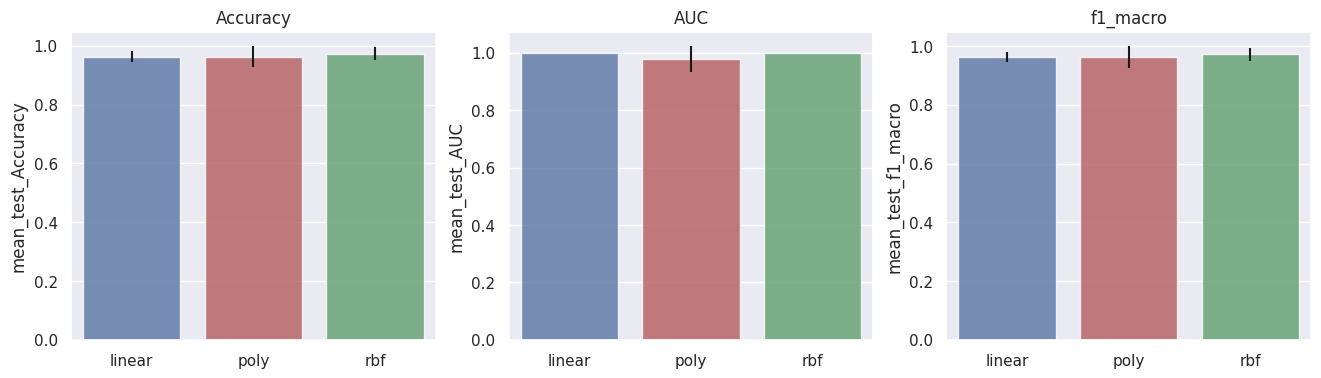

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
plt.subplot(1, 3, 1)
sns.barplot(x = "params", y = "mean_test_Accuracy", palette = ['b', 'r', 'g'], alpha = 0.8,
            data = df, yerr=df["std_test_Accuracy"]).set(title = 'Accuracy', xlabel="")

plt.subplot(1, 3, 2)
sns.barplot(x = "params", y = "mean_test_AUC", palette = ['b', 'r', 'g'], alpha = 0.8,
            data = df, yerr=df["std_test_AUC"]).set(title = 'AUC', xlabel="")

plt.subplot(1, 3, 3)
sns.barplot(x = "params", y = "mean_test_f1_macro", palette = ['b', 'r', 'g'], alpha = 0.8,
            data = df, yerr=df["std_test_f1_macro"]).set(title = 'f1_macro', xlabel="")

In [ ]:
#добавим параметров и посмотрим, что будет. Начнем с параметра регуляризации
opt = GridSearchCV(
    SVC(),
    {
        'C': (1e-4, 1e-3, 1e-2, 1e-1, 1e+1, 1e+2, 1e+3, 1e+4),
       # 'gamma': (1e-6, 1e+1, 'log-uniform'),
       # 'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],
    },
    scoring=scoring,
    refit=False,
    cv=5
)

opt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 10.0, 100.0, 1000.0,
                               10000.0),
                         'kernel': ['linear', 'poly', 'rbf']},
             refit=False,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy',
                      'f1_macro': 'f1_macro'})

In [ ]:
df_c = pd.DataFrame()
for key in results_keys:
        print(key, " : ", opt.cv_results_[key])
        df_c[key] = opt.cv_results_[key]
#результаты выглядят интересно, тк появились низкие Accuracy и f1. Попробуем визуализировать

params  :  [{'C': 1000.0, 'kernel': 'linear'}, {'C': 1000.0, 'kernel': 'poly'}, {'C': 1000.0, 'kernel': 'rbf'}, {'C': 10000.0, 'kernel': 'linear'}, {'C': 10000.0, 'kernel': 'poly'}, {'C': 10000.0, 'kernel': 'rbf'}, {'C': 100000.0, 'kernel': 'linear'}, {'C': 100000.0, 'kernel': 'poly'}, {'C': 100000.0, 'kernel': 'rbf'}, {'C': 1000000.0, 'kernel': 'linear'}, {'C': 1000000.0, 'kernel': 'poly'}, {'C': 1000000.0, 'kernel': 'rbf'}, {'C': 10000000.0, 'kernel': 'linear'}, {'C': 10000000.0, 'kernel': 'poly'}, {'C': 10000000.0, 'kernel': 'rbf'}, {'C': 100000000.0, 'kernel': 'linear'}, {'C': 100000000.0, 'kernel': 'poly'}, {'C': 100000000.0, 'kernel': 'rbf'}]
mean_test_AUC  :  [0.99814815 1.         1.         0.99814815 1.         1.
 0.99814815 1.         1.         0.99814815 1.         1.
 0.99814815 1.         1.         0.99814815 1.         1.        ]
std_test_AUC  :  [0.0037037 0.        0.        0.0037037 0.        0.        0.0037037
 0.        0.        0.0037037 0.        0.        

In [ ]:
df_c['kernel'] = df_c.params.apply(lambda x: x['kernel'])
df_c['C'] = df_c.params.apply(lambda x: x['C'])
df_c.head(1)

,params,mean_test_AUC,std_test_AUC,mean_test_Accuracy,std_test_Accuracy,mean_test_f1_macro,std_test_f1_macro,kernel,C
0,"{'C': 1000.0, 'kernel': 'linear'}",0.998148,0.003704,0.972294,0.022635,0.971898,0.022988,linear,1000.0


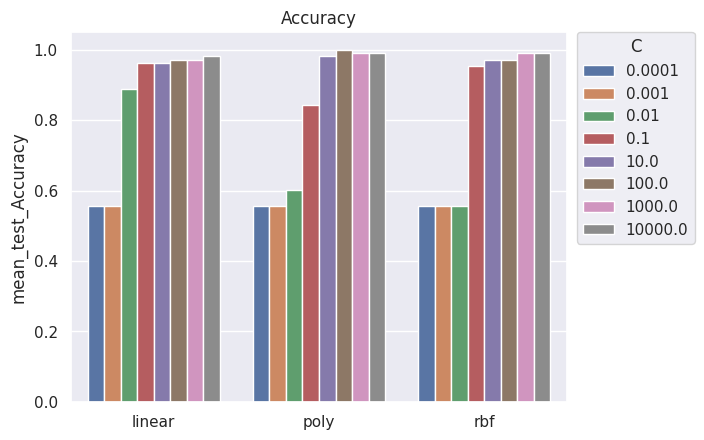

In [ ]:
sns.barplot(x = "kernel", y = "mean_test_Accuracy", hue="C",
            data = df_c).set(title = 'Accuracy', xlabel="") #yerr=df_c["std_test_Accuracy"],

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='C'); #это чтобы легенда была за границами, потому что иначе она налезает на график

#Видим, что самый высокий столбец у poly+ 100.0, и еще хорошо себя показывает rbf и poly 1000 и 10000, а также linear 10000

In [ ]:
"""
К вопросу о чувствительности параметров:
Видим, что accuracy чертовски хорошая на С 10+ и ужасная при < 0.01. При этом это при всех ядрах, то есть они все достаточно чувствительны к С
"""

In [ ]:
#Посмотрим еще большие параметры, чтобы точно удостовериться, что мы ничего не пропустили
opt = GridSearchCV(
    SVC(),
    {
        'C': (1e+3, 1e+4, 1e+5, 1e+6, 1e+7, 1e+8),
       # 'gamma': (1e-6, 1e+1, 'log-uniform'),
       # 'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],
    },
    scoring=scoring,
    refit=False,
    cv=5
)

opt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': (1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0,
                               100000000.0),
                         'kernel': ['linear', 'poly', 'rbf']},
             refit=False,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy',
                      'f1_macro': 'f1_macro'})

In [ ]:
df_c_high = pd.DataFrame()
for key in results_keys:
        print(key, " : ", opt.cv_results_[key])
        df_c_high[key] = opt.cv_results_[key]

params  :  [{'C': 1000.0, 'kernel': 'linear'}, {'C': 1000.0, 'kernel': 'poly'}, {'C': 1000.0, 'kernel': 'rbf'}, {'C': 10000.0, 'kernel': 'linear'}, {'C': 10000.0, 'kernel': 'poly'}, {'C': 10000.0, 'kernel': 'rbf'}, {'C': 100000.0, 'kernel': 'linear'}, {'C': 100000.0, 'kernel': 'poly'}, {'C': 100000.0, 'kernel': 'rbf'}, {'C': 1000000.0, 'kernel': 'linear'}, {'C': 1000000.0, 'kernel': 'poly'}, {'C': 1000000.0, 'kernel': 'rbf'}, {'C': 10000000.0, 'kernel': 'linear'}, {'C': 10000000.0, 'kernel': 'poly'}, {'C': 10000000.0, 'kernel': 'rbf'}, {'C': 100000000.0, 'kernel': 'linear'}, {'C': 100000000.0, 'kernel': 'poly'}, {'C': 100000000.0, 'kernel': 'rbf'}]
mean_test_AUC  :  [0.99814815 1.         1.         0.99814815 1.         1.
 0.99814815 1.         1.         0.99814815 1.         1.
 0.99814815 1.         1.         0.99814815 1.         1.        ]
std_test_AUC  :  [0.0037037 0.        0.        0.0037037 0.        0.        0.0037037
 0.        0.        0.0037037 0.        0.        

In [ ]:
df_c_relevant = df_c[df_c.C > 9]
df_c_relevant.head()

,params,mean_test_AUC,std_test_AUC,mean_test_Accuracy,std_test_Accuracy,mean_test_f1_macro,std_test_f1_macro,kernel,C
0,"{'C': 1000.0, 'kernel': 'linear'}",0.998148,0.003704,0.972294,0.022635,0.971898,0.022988,linear,1000.0
1,"{'C': 1000.0, 'kernel': 'poly'}",1.000000,0.000000,0.990909,0.018182,0.990737,0.018526,poly,1000.0
2,"{'C': 1000.0, 'kernel': 'rbf'}",1.000000,0.000000,0.990909,0.018182,0.990737,0.018526,rbf,1000.0
3,"{'C': 10000.0, 'kernel': 'linear'}",0.998148,0.003704,0.981385,0.022809,0.981008,0.023293,linear,10000.0
4,"{'C': 10000.0, 'kernel': 'poly'}",1.000000,0.000000,0.990909,0.018182,0.990737,0.018526,poly,10000.0


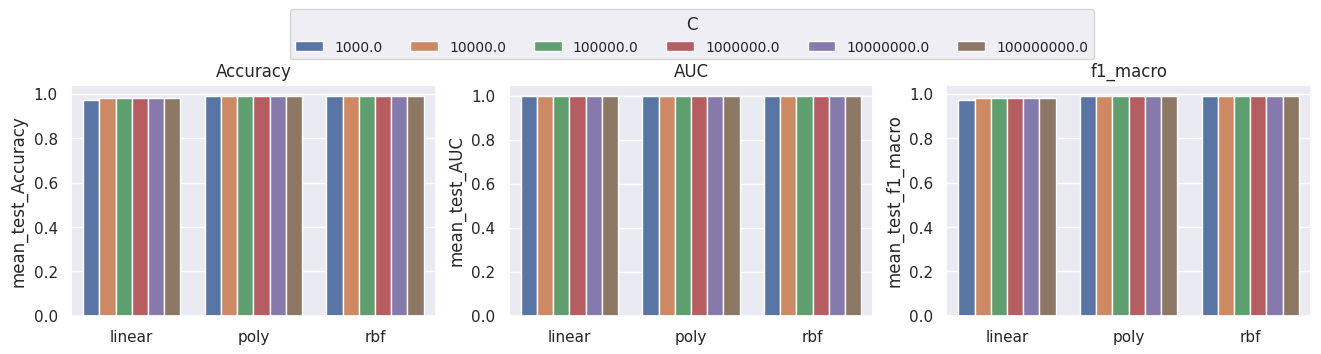

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))
plt.subplot(1, 3, 1)
sns.barplot(x = "kernel", y = "mean_test_Accuracy", hue="C",
            data = df_c_relevant).set(title = 'Accuracy', xlabel="")
plt.legend([],[], frameon=False)

plt.subplot(1, 3, 2)
sns.barplot(x = "kernel", y = "mean_test_AUC", hue="C",
            data = df_c_relevant).set(title = 'AUC', xlabel="", )
plt.legend(bbox_to_anchor=(-0.6, 1.11, 1, 0.2), borderaxespad=0, title='C', fontsize=10, ncol=6, loc='lower left')

plt.subplot(1, 3, 3)
sns.barplot(x = "kernel", y = "mean_test_f1_macro", hue="C",
            data = df_c_relevant).set(title = 'f1_macro', xlabel="")
plt.legend([],[], frameon=False);


In [ ]:
"""
Я делала кросс-вал на этапе подбора параметров, поэтому переобучения быть не должно
Также std достаточно маленькие, так что выглядит так, что переобучения нет, но на всякий случай проверю на примере
"""

In [ ]:
model = SVC(C=1e+4, kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.95      0.97        19

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36

